# AutoUSD, sUSDe, Aave USDC and BIL (1-3 month T-Bill ETF) Comparison

Task:


> 
> Metrics:
> APY  
> Yield Volatility (annualized)  
> Excess vs 3M T-Bill  
> Information Ratio  
> For products:  
> USD: autoUSD, Ethena sUSDe, Aave USDC lending, US Gov short term treasuries  
> ETH: autoETH, Lido staking (stETH), Aave ETH lending  
> Time periods: 30 day, 1 year, since inception  
> *no 1 year on autoUSD since <1 year old  
> Definitions:  
> Yield Volatility: stdev of monthly net returns × √12  
> Excess vs Benchmark: difference between average net APY and the benchmark (3M T-bill for USD; Lido staking rate for ETH).  
> Information Ratio: average monthly excess return ÷ stdev of monthly excess returns, annualized  


# Methods


## Data sources:

Onchain calls on mainnet at the last block of each day

- autoUSD.converToAssets(1e18) / 1e6 -> USDC value of one autoUSD share
- sUSDe -> chainlink sUSDE -> USD oracle, safe USD value of sUSDe over time.
- Aave USDC lending, stataAaveUSDC.convertToAssets(1e6) / 1e6, growth of a share of the aave USDC vault

BIL `SPDR Bloomberg 1-3 Month T-Bill ETF`

https://www.ssga.com/us/en/intermediary/etfs/spdr-bloomberg-1-3-month-t-bill-etf-bil 

> The SPDR® Bloomberg  1-3 Month T-Bill ETF seeks to provide investment results that, before fees and expenses, correspond generally to the price and yield performance of the Bloomberg  1-3 Month U.S. Treasury Bill Index (the "Index")  
> Seeks to provide exposure to publicly issued U.S. Treasury Bills that have a remaining maturities between 1 and 3 months  
> Short duration fixed income is less exposed to fluctuations in interest rates than longer duration securities  
> Rebalanced on the last business day of the month  


As of Oct 26, 2025 BIL has ~42.5B AUM

```
!pip install yfinance
import yfinance as yf
tickers = ['BIL']
data = yf.download(tickers, start="2024-10-26", end="2025-10-26", actions=True)
data.to_csv('data.csv')

```



In [10]:
from multicall import Call

import pandas as pd
import numpy as np
import plotly.express as px

from mainnet_launch.data_fetching.get_state_by_block import (
    get_state_by_one_block,
    build_blocks_to_use,
    get_raw_state_by_blocks,
    safe_normalize_6_with_bool_success,
    safe_normalize_with_bool_success,
)
from mainnet_launch.constants import ETH_CHAIN, AUTO_ETH


# https://etherscan.io/address/0x73edDFa87C71ADdC275c2b9890f5c3a8480bC9E6#readProxyContract
# chainlink safe price of sUSDe over time
# https://etherscan.io/address/0x98C23E9d8f34FEFb1B7BD6a91B7FF122F4e16F5c aave USDC
# https://data.chain.link/feeds/ethereum/mainnet/susde-usd


def _process_chainlink_usd_price(success, args):
    """
    Normalize Chainlink latestRoundData -> price as float (answer / 1e6).
    args is: (roundId:uint80, answer:int256, startedAt:uint256, updatedAt:uint256, answeredInRound:uint80)
    """
    round_id, answer, started_at, updated_at, answered_in_round = args
    if success:
        return float(answer) / 1e18


stETH_ETH_chainlink_oracle = "0x86392dC19c0b719886221c78AB11eb8Cf5c52812"

chainlink_stETH_price_call = Call(
    stETH_ETH_chainlink_oracle,
    ["latestRoundData()((uint80,int256,uint256,uint256,uint80))"],
    [("stETH_ETH_safe_price", _process_chainlink_usd_price)],
)

stata_aave = "0xC077F28FC0f10C886253E67Be402A7F7D611D4EE"  # convert to shares calls


aave_convert_to_shares_call = Call(
    stata_aave,
    ["convertToAssets(uint256)(uint256)", int(1e18)],
    [("WETH_aave", safe_normalize_with_bool_success)],
)

autoETH_nav_per_share_call = Call(
    AUTO_ETH.autopool_eth_addr,
    ["convertToAssets(uint256)(uint256)", int(1e18)],
    [("autoETH", safe_normalize_with_bool_success)],
)

wstETH = "0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0"

wstETH_convert_to_shares_call = Call(
    wstETH,
    ["stEthPerToken()(uint256)"],
    [("wstETH", safe_normalize_with_bool_success)],
)


insta_dapp_stETH_looping = "0xA0D3707c569ff8C87FA923d3823eC5D81c98Be78"

ieth_convert_to_assets_call = Call(
    insta_dapp_stETH_looping,
    ["convertToAssets(uint256)(uint256)", int(1e18)],  # 1.0 share → assets
    [("iETH_v2", safe_normalize_with_bool_success)],
)


end_of_day_oct_26_2024_block = 21053236
blocks = build_blocks_to_use(ETH_CHAIN, start_block=end_of_day_oct_26_2024_block)
near_end_of_day_nov_3_block = 23722126
blocks.append(near_end_of_day_nov_3_block)
df = get_raw_state_by_blocks(
    calls=[
        aave_convert_to_shares_call,
        chainlink_stETH_price_call,
        autoETH_nav_per_share_call,
        wstETH_convert_to_shares_call,
        ieth_convert_to_assets_call,
    ],
    blocks=blocks,
    chain=ETH_CHAIN,
)

df["wstETH_eth_price"] = df["wstETH"] * df["stETH_ETH_safe_price"]
df["iETH_v2_eth_price"] = df["iETH_v2"] * df["stETH_ETH_safe_price"]
df = df[["autoETH", "WETH_aave", "wstETH_eth_price", "iETH_v2_eth_price"]]
# df = df[df.index > "2024-11-03"].copy()
df

,autoETH,WETH_aave,wstETH_eth_price,iETH_v2_eth_price
timestamp,,,,
2024-10-26 23:59:59+00:00,1.002042,1.033575,1.182742,1.127189
2024-10-27 23:59:59+00:00,1.002097,1.033633,1.182595,1.127002
2024-10-28 23:59:59+00:00,1.002281,1.033691,1.182650,1.127147
2024-10-29 23:59:59+00:00,1.001945,1.033760,1.182739,1.127352
2024-10-30 23:59:59+00:00,1.001997,1.033817,1.182925,1.127635
...,...,...,...,...
2025-10-30 23:59:59+00:00,1.054015,1.054976,1.217837,1.185028
2025-10-31 23:59:59+00:00,1.054047,1.055029,1.217575,1.184776
2025-11-01 23:59:59+00:00,1.053882,1.055082,1.217657,1.184829


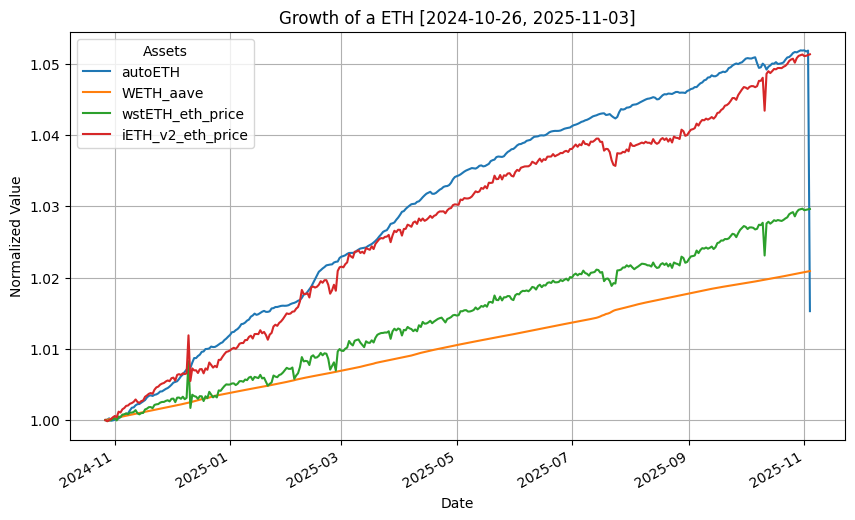

In [11]:
import matplotlib.pyplot as plt

first_na_value = df.apply(lambda col: col.loc[col.first_valid_index()])
norm_one_recent_df = df / first_na_value
norm_one_recent_df.plot(title=f"Growth of a ETH [{df.index.min().date()}, {df.index.max().date()}]", figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend(title="Assets")
plt.grid(True)
plt.show()

In [12]:
def get_apy_values(norm_one_recent_df: pd.DataFrame):
    start, end = norm_one_recent_df.iloc[0], norm_one_recent_df.iloc[-1]
    days = (norm_one_recent_df.index[-1] - norm_one_recent_df.index[0]).days
    years = days / 365

    all_time_apy = ((end / start) ** (1 / years)) - 1

    start, end = norm_one_recent_df.iloc[-30], norm_one_recent_df.iloc[-1]
    days = (norm_one_recent_df.index[-1] - norm_one_recent_df.index[-30]).days
    years = days / 365

    month_apy = ((end / start) ** (1 / years)) - 1

    return 100 * all_time_apy, 100 * month_apy


def determine_excess_vs_bench_mark(apy_df, bench_mark_column: str):
    results = {}
    for col in apy_df.index:
        if col != bench_mark_column:
            excess_apy = apy_df[col] - apy_df[bench_mark_column]
            results[col] = excess_apy
    return pd.Series(results)


def compute_monthly_growth(norm_one_recent_df: pd.DataFrame) -> pd.DataFrame:
    norm_one_recent_df.index = pd.to_datetime(norm_one_recent_df.index)
    end_of_month_values = norm_one_recent_df.resample("ME").last()
    monthly_growth = ((end_of_month_values / end_of_month_values.shift(1)) - 1) * 100
    return monthly_growth


def compute_yield_volatility(monthly_returns: pd.Series) -> float:
    # Yield Volatility: stdev of monthly net returns × √12
    return monthly_returns.std(ddof=1) * np.sqrt(12)  # not annualized


def compute_information_ratio(end_of_month_values: pd.DataFrame, benchmark_column: str) -> pd.Series:
    # Information Ratio: average monthly excess return ÷ stdev of monthly excess returns, annualized
    monthly_growth_annualized = (((end_of_month_values / end_of_month_values.shift(1)) ** 12) - 1) * 100
    excess_return = monthly_growth_annualized.sub(monthly_growth_annualized[benchmark_column], axis=0)
    mean_excess_return = excess_return.mean()
    std_monthly_excess_return = excess_return.std(ddof=1)
    information_ratio = mean_excess_return / std_monthly_excess_return
    return information_ratio


def build_info_df(
    stable_coins_30_day_apy,
    stable_coins_all_time_apy,
    vs_benchmark_30_day,
    vs_benchmark_all_time,
    yield_volatility,
    information_ratio,
):

    stable_coins_all_time_apy["metric"] = "All Time APY"
    stable_coins_30_day_apy["metric"] = "30 Day APY"
    vs_benchmark_30_day["metric"] = "30 Day Excess vs Benchmark"
    vs_benchmark_all_time["metric"] = "All Time Excess vs Benchmark"
    yield_volatility["metric"] = "Yield Volatility"
    information_ratio["metric"] = "Information Ratio"

    info_df = pd.concat(
        [
            stable_coins_all_time_apy,
            stable_coins_30_day_apy,
            vs_benchmark_all_time,
            vs_benchmark_30_day,
            yield_volatility,
            information_ratio,
        ],
        axis=1,
    )
    info_df.columns = info_df.loc["metric"]
    info_df = info_df.drop("metric")
    # set each of those dtypes to float
    info_df = info_df.astype(float)
    return info_df


def compute_metrics(norm_one_recent_df: pd.DataFrame, benchmark_column: str = "wstETH_eth_price"):
    stable_coins_all_time_apy, stable_coins_30_day_apy = get_apy_values(norm_one_recent_df)
    vs_benchmark_all_time = determine_excess_vs_bench_mark(stable_coins_all_time_apy, benchmark_column)
    vs_benchmark_30_day = determine_excess_vs_bench_mark(stable_coins_30_day_apy, benchmark_column)

    monthly_growth = compute_monthly_growth(norm_one_recent_df)
    yield_volatility = monthly_growth.apply(compute_yield_volatility)
    information_ratio = compute_information_ratio(
        norm_one_recent_df.resample("ME").last(), benchmark_column=benchmark_column
    )

    return (
        stable_coins_all_time_apy,
        stable_coins_30_day_apy,
        vs_benchmark_all_time,
        vs_benchmark_30_day,
        yield_volatility,
        information_ratio,
    )


(
    stable_coins_all_time_apy,
    stable_coins_30_day_apy,
    vs_benchmark_all_time,
    vs_benchmark_30_day,
    yield_volatility,
    information_ratio,
) = compute_metrics(norm_one_recent_df)
info_df = build_info_df(
    stable_coins_30_day_apy,
    stable_coins_all_time_apy,
    vs_benchmark_30_day,
    vs_benchmark_all_time,
    yield_volatility,
    information_ratio,
)
print(info_df.round(4).to_markdown())

|                   |   All Time APY |   30 Day APY |   All Time Excess vs Benchmark |   30 Day Excess vs Benchmark |   Yield Volatility |   Information Ratio |
|:------------------|---------------:|-------------:|-------------------------------:|-----------------------------:|-------------------:|--------------------:|
| autoETH           |         1.4999 |     -36.2174 |                        -1.4064 |                     -39.9244 |             3.797  |             -0.0542 |
| WETH_aave         |         2.0512 |       1.875  |                        -0.8552 |                      -1.832  |             0.1668 |             -0.6795 |
| wstETH_eth_price  |         2.9064 |       3.707  |                       nan      |                     nan      |             0.3519 |            nan      |
| iETH_v2_eth_price |         5.0351 |       5.9042 |                         2.1288 |                       2.1973 |             0.6783 |              1.2482 |


: 

: 

: 